# Imports

# New Section

In [ ]:
!pip install control
# Colab does not come with this library
import control
import cmath
# Allows you to make complex numbers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
from numpy.typing import ArrayLike
from typing import List
from typing import Tuple
# from typing import str
from math import pi

# Practicum 3-1
Week 1 of the project!

## DCMotor
**DCMotorConfig**, **DCMotorDynamics**, and **DCMotor** are the classes we made for Practicum 2 to handle all of our DCMotor stuff. It's copied here, mostly unchanged from last week, for us to make a controller for it later! Since I thoroughly documented it last time, I won't repeat that here. Just for my own reference:
$$\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}\equiv
\begin{bmatrix}
i \\
\theta \\
\dot{\theta}
\end{bmatrix}$$

The one change I made was adding a member variable for the C matrix to **DCMotor**. This is so I can use it when calculating the feedforwad gain, $k_f$, later. I also updated my **output()** method to use this matrix.

In [ ]:
from dataclasses import dataclass
@dataclass
class DCMotorConfig:
  """Store constant values for a DC Motor.
  
  R: float: resistance (Ohms)
  L: float: inductance (Henry)
  b: float: dampening (Nms)
  J: float: moment of inertia (kgm^2)
  K_m: float: back emf constant
  K_tau: float: motor torque constant"""
  R: float
  L: float
  b: float
  J: float
  Km: float
  Ktau: float

  
class DCMotorDynamics:
  """Dynamics for a DC motor."""
  def __init__(self, motor_cfg: DCMotorConfig) -> None:
    """Create A and B matrices from the motor_cfg.
    
    motor_cfg: DCMotorConfig: dc motor config constants"""
    self.A = np.array([[-1*motor_cfg.R/motor_cfg.L, 0, -1*motor_cfg.Km/motor_cfg.L],
                       [0, 0, 1],
                       [motor_cfg.Ktau/motor_cfg.J, 0, -1*motor_cfg.b/motor_cfg.J]])
    self.B = np.array([[1/motor_cfg.L],
                       [0],
                       [0]])
  def __call__(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub.
    
    x: ArrayLike: x
    u: float: input"""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

class DCMotor:
  """Wrapper that abstracts away DCMotorDynamics."""
  def __init__(self, cfg: DCMotorConfig) -> None:
    """Inits dynamics.
    
    cfg: DCMotorConfig: dc motor config constants"""
    self.config = cfg
    self.dynamics = DCMotorDynamics(cfg)
    self.C = np.array([0, 1, 0])
  
  def output(self, x: ArrayLike) -> float:
    """Returns theta.
    
    x: ArrayLike: x"""
    return self.C@x

Just to make sure this refactor of the output function didn't change anything, I'm going to re-create Evaluation 1 from Practicum 2-1. 

I disliked how the column vectors were printed, so I wrote a function to decrease the precision that was printed, but then I google'd it and there's a way to change that setting in numpy... So, the Evaluation 1 printed output shows what my function prints, and 2 and 3 show the default numpy printing when changing the precision to 3.

In [ ]:
def pretty_column_print(list: ArrayLike):
  """Print column vectors with less precision."""
  to_print = "["
  for x in list:
    to_print += f"[{f'{x[0]:.2f}': ^8}]\n "
  print(to_print[:-2] + "]")

# I could've just used this...
np.set_printoptions(precision=3)

cfg = DCMotorConfig(R=1.8, L=0.85e-2, Km=4.6, Ktau=6.2, b=0.035, J=0.032)
dcmotor1 = DCMotor(cfg=cfg)
print(f"Evaluation 1:")
pretty_column_print(dcmotor1.dynamics(x=np.array([[0], [0], [0]]), u=2.0))
print(f"Evaluation 2:\n{dcmotor1.dynamics(x=np.array([[0], [0], [0]]), u=-2.0)}")
print(f"Evaluation 3:\n{dcmotor1.dynamics(x=np.array([[1], [0], [0]]), u=0.0)}")

Evaluation 1:
[[ 235.29 ]
 [  0.00  ]
 [  0.00  ]]
Evaluation 2:
[[-235.294]
 [   0.   ]
 [   0.   ]]
Evaluation 3:
[[-211.765]
 [   0.   ]
 [ 193.75 ]]


As expected, these outputs match Evaluation 1 from Practicum 2-1, except they are now column vectors instead of row vectors as before. Hopefully this doesn't break anything later! *Foreshadowing is a literary device...*

In [ ]:
print(f"Evaluation 4: {dcmotor1.output(np.array([0, 1, 2]))}")

Evaluation 4: 1


This is just a simple test to make sure that the 2nd item in the array is still being returned with the refactored **output()** method and, indeed, it is.

## Controllability
To determine controllability, we need to first calculate the controllability grammian. **ctrb()** implements the following equation to do so, assuming an N-dimensional system:

$$C = [B \quad AB ... A^{n-1}B]$$

This occurs in the following steps:
  1. Create a C matrix that contains the first term, just B.
  ```
  C = B
  ```
  1. Enter for loop with boundary conditions based on the shape of A.
  ```
  for i in range (1, A.shape)
  ```
    1. Raise A to the power of the iterator.
    ```
    A = np.matrix_power(A, i)
    ```
    1. Multiply it by B.
    ```
    A = A@B
    ```
    1. Horizontally stack this onto the C matrix.
    ```
    np.hstack(C, A)
    ```

In [ ]:
def ctrb(A: ArrayLike, B: ArrayLike) -> ArrayLike:
  """Return the controlability matrix.
  C = [B AB...]"""
  C = B
  for i in range(1, A.shape[0]):
    temp_a = np.linalg.matrix_power(A, i)
    C = np.hstack((C, temp_a@B))
  return C

I then wrote a function that takes the controllability matrix we just calculated and determins if it's controllable or not. All this function does is calculate the determinite of C, and returns a boolean.

If the determinant != 0, then we know that it's full rank, making it controllable! We return True in this case. If the determinant = 0, then it's not controllable and we return False :(

In [ ]:
def is_controllable(C: ArrayLike) -> bool:
  """Calculates determinate of C. If != 0,
  is full rank, and therefore controllable."""
  if np.linalg.det(C) == '0':
    return False
  else:
    return True

Testing **ctrb()**: We can manually calculate the controllability formula for some values and pass them in and ensure the output matches.

$$\dot{x}=\begin{bmatrix}
1 & 2 \\
0 & -3
\end{bmatrix}x +
\begin{bmatrix}
0 \\
1
\end{bmatrix}u
$$
The formula to calculate the controllability grammian for this model is:
$$C = [B \quad AB]$$
First, I'll calculate AB:
$$AB=\begin{bmatrix}
1 & 2 \\
0 & -3
\end{bmatrix}
\begin{bmatrix}
0 \\
1
\end{bmatrix}
$$
$$
AB=\begin{bmatrix}
2 \\
-3
\end{bmatrix}
$$
Therefore:
$$C = [B \quad AB]$$
$$
C=\begin{bmatrix}
0 & 2 \\
1 & -3
\end{bmatrix}
$$


In [ ]:
C = ctrb(A=np.array([[1, 2], [0, -3]]), B=np.array([[0], [1]]))
print(f"C =\n{C}")

C =
[[ 0  2]
 [ 1 -3]]


We can see the output of our **ctrb()** function is what we expect!

Testing **is_controllable():** We can manually calculate the determinant of this controllability grammian and then pass it in to ensure the output is correct based on that.

$$A=\begin{bmatrix}
a & b \\
c & d \\
\end{bmatrix}
\begin{vmatrix}
A
\end{vmatrix}=ad-bc \\
C=\begin{bmatrix}
0 & 2 \\
1 & -3
\end{bmatrix} \\
\begin{vmatrix}
C
\end{vmatrix}= (0)(-3) - (2)(1) \\
\begin{vmatrix}
C
\end{vmatrix}=-2
$$
Since our determinant of C is nonzero, we know that it's full rank, meaning it is controllable!

In [ ]:
print(f"True/False, C is controllable: {is_controllable(C)}")

True/False, C is controllable: True


Our **is_controllable()** outputs what we expect for the controllability of C!

## Evaluation 1
I'm going to check the controllability of the DC motor model we've defined using  **ctrb()** and **is_controllable()**. I'll then check the eigenvalues and talk about what they all mean.

I also wrote a **pretty_row_print()** function because I disliked how the output looked for this row vector. All it does is go through each value in a row vector, printing each comma-delimited value at a precision of 2, wrapping the whole thing in brackets. This was entirely unnecessary, but I like the output.

In [ ]:
def pretty_row_print(list: ArrayLike):
  """Add commas, remove weird padding, 
  change the precision of the output of 
  a row vector and print it."""
  to_print = "["
  for x in list:
    to_print += f"{x:.2f}, "
  print(to_print[:-2] + "]")

C = ctrb(A=dcmotor1.dynamics.A,B=dcmotor1.dynamics.B)
print(f"True/False, C is controllable: {is_controllable(C)}")
print(f"Eigenvalues for this plant: ", end="")
pretty_row_print(np.linalg.eigvals(dcmotor1.dynamics.A))

True/False, C is controllable: True
Eigenvalues for this plant: [0.00+0.00j, -106.43+306.20j, -106.43-306.20j]


### Reflection
My controllability function says that this DC model is controllable! Its eigenvalues both have negative real components, which means it's nominally stable! Controllability checks both the A and B matrix together, whereas stability only checks A.

These results make sense - we discussed in lecture that nominally stable essentially means it remains stable until it receives an input, and then it's no longer stable. That makes sense for a DC motor - once it's powered, it will turn, and it won't return back to its original position until it receives power again.

## State Feedback Regulator
**StateFeedbackRegulator** implements a state feedback controller, using passed vales for $K$, $K_f$, and setpoint (or $r$).
![State Feedback Regulator](https://drive.google.com/uc?export=view&id=1GBiB4joBPKAaFGgXIB_-vvPn0LA6DLKV)
$$\text{Figure taken from page 7-10 of FBS}$$

* **init** stores the constant values for $K$, $K_f$, and **setpoint** as member variables.
* **call** function implements state feedback control. It takes a measurement, $x$, as an argument and returns the input value. $u$. It implements:
$u=-kx+k_f*r$

A state feedback controller essentially takes the current output, or *feedback*, of our system and uses that to adjust the state of said system. It does this using closed loop poles / eigenvalues; providing an input to achieve a stable output reaching the desired setpoint, $r$. 

In theory, poles are chosen for desired system characteristics. This week we're arbitrarily using poles Dr. Martin has provided for us and seeing how they affect our system, but next week we'll be implementing a way to design our own!

In [ ]:
class StateFeedbackRegulator:
  def __init__(self,
               K: ArrayLike,
               k_f: float,
               setpoint: float) -> None:
    """Store K, k_f, and setpoint for use by the __call__ routine."""
    self.k = K
    self.k_f = k_f
    self.setpoint = setpoint

  def __call__(self, x: ArrayLike) -> float:
    """Compute the state feedback regulator as discussed in class
    Note: u should be a scalar since this is a single input system."""
    return -1 * self.k @ x +self.k_f*self.setpoint


One of the constants of our **StateFeedbackRegulator** class is $k_f$, which needs to be passed to the constructor. **feedforward_gain()** implents the following equation:
$$k_f=\frac{-1}{C(A-BK)^{-1}B}$$
It basically starts from the innermost part of the equation in the denominator and works its way back out.

In [ ]:
def feedforward_gain(K: ArrayLike,
                     A: ArrayLike,
                     B: ArrayLike,
                     C: ArrayLike) -> float:
  """Calculate the feedforward gain."""
  denom_temp = (A-B@K)
  denom_temp = np.linalg.inv(denom_temp)
  denom_temp = C@denom_temp
  denom = denom_temp@B
  return -1/denom

Now we have everything we neeed for a state feedback controller! Before we get into the integration, let's just try passing it some values and seeing what we get back...

In [ ]:
A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C

# These numbers are pretty small...
np.set_printoptions(precision=6)
K = control.acker(A=A, B=B, poles=[-2,-6-6j,-6+6j])
print(f"K value from our DC motor: {K}")
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
print(f"K_f value from our DC motor: {K_f}")
state_reg = StateFeedbackRegulator(K=K, k_f=K_f, setpoint=0)
print("\nTrying out the state feedback regulator with a setpoint of 0:")
print(f"U value with a non-zero current: {state_reg(np.array([[1],[0],[0]]))}")
print(f"U value with a non-zero position: {state_reg(np.array([[0],[1],[0]]))}")
print(f"U value with a non-zero speed: {state_reg(np.array([[0],[0],[1]]))}")

K value from our DC motor: [[-1.690297  0.006317 -4.596408]]
K_f value from our DC motor: [0.006317]

Trying out the state feedback regulator with a setpoint of 0:
U value with a non-zero current: [[1.690297]]
U value with a non-zero position: [[-0.006317]]
U value with a non-zero speed: [[4.596408]]


Honestly, I'm not quite sure what to expect here. Anything non-zero probably seems good. Abdul & I compared our $k_f$ values and we got the same thing, which is reassuring. 

Knowing what I know about the DC Motor, I think the U-value tests make sense. With a setpoint of 0, it makes sense that the U-value is largest with a non-zero speed, slightly smaller with a non-zero current, and very tiny with a non-zero position. The speed and current directly affect the position (what we're trying to get to 0), whereas the position itself doesn't really affect that.

It will take integration/simulation tests to know for sure, though, which is what I'm doing next!

## Integration
My tech debt finally caught up with me. For this week's matrix calculations to work, I needed to use a column vector as my initial conditions instead of a row vector. Unfortunately, my **rk2_step()** and **simulate()** functions both expect my initial conditions to be a row vector, so they don't work now that I'm using column vectors.

Fortunately, splitting the stepper and simulate functions up last week helps me out immensely here. Since the inputs only need to be a column vector when doing the stepping, I can make a switcharoo in the stepper function. I transpose the row vector x values passed in, do the calculations as a column vector, and transpose it back to a row to pass it back to the simulate() function. I didn't think such a short shoddy workaround would do the trick, but it does. *Certainly, this won't bite me in the rear again later on in this course...*

The only other change made here is the lambda for the u func in **simulate()** to account for the fact that our new controller takes in our entire set of x values instead of just position.

Everything else is the same as Practicum 2, so I'll avoid re-explaining all of that for brevity.

In [ ]:
from typing import Callable

def rk2_step(dyn_func: Callable,
             u_func: Callable,
             x: ArrayLike,
             t: float,
             delta_t: float) -> ArrayLike:
  """Computing f1, f2, and x_k_1. Contains a workaroud
  to the fact that I misunderstood how to write this simulate
  function day1, and have been working with row vectors since,
  when in reality I should've been using columns.
  
  dyn_func: Callable: function being integrated
  u_func: Callable: input function
  x: ArrayLike: x_k value using to estimate x_k_1
  t: float: current time 
  delta_t: float: time step"""
  # Converting the input from a column to a row vector
  x = np.atleast_2d(x).T
  
  f_1 = dyn_func(x=x,u=u_func(t))
  f_2 = dyn_func(x=x + delta_t/2*f_1, u=u_func(t+delta_t/2))

  x_k_1 = x + delta_t*f_2
  # Converting the output from a row to a column vector
  x_k_1 = x_k_1.T
  return x_k_1

def simulate(plant, 
             controller,
             x_0: ArrayLike,
             t_0: float,
             t_f: float,
             delta_t: float) -> Tuple[ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Using our stepper
  for i in range(1, len(t_vals)):
    u_func = lambda t, state=x_vals[i-1]: controller(state)
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
  return t_vals, x_vals

## Plotter
Per usual, I went over the top and wrote a function to do all my plotting. This time, it's so I can plot the three different sets of poles in separate blocks to do my calculations after each. I've broken down the structure of my plotting functions before, so I won't needlessly repeat myself here.

In [ ]:
def eval2_plot(plant,
               controller,
               x_0: ArrayLike,
               duration: float, 
               delta_t: float,
               title: str):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  plt.figure(figsize=(12,5))
  
  # Simulate
  t_vals, x_vals = simulate(plant=plant,
                            controller=controller,
                            x_0=x_0,
                            t_0=0,
                            t_f=duration,
                            delta_t=delta_t)
  # Plot
  plt.plot(t_vals, [x[1] for x in x_vals])
  
  # Adding appropriate labels
  plt.title(title)
  plt.grid(which='major', color='#AAAAAA', linewidth=1.0)
  plt.grid(which='minor', color='#DDDDDD', linewidth=0.8)
  plt.minorticks_on()
  plt.xlabel("Time $(s)$")
  plt.ylabel("Position $(\Theta)$")

## Evaluation 2
We haven't quite gotten to designing our own poles yet, so this evaluation is plotting three different sets of poles with our state feedback regulator and DC motor to investigate how they impact our response.

In [ ]:
# Input constants
duration = 6
delta_t=0.001
cfg = DCMotorConfig(R=1.8, L=0.85e-2, Km=4.6, Ktau=6.2, b=0.035, J=0.032)
dcmotor1 = DCMotor(cfg=cfg)

A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C

### Pole Set 1

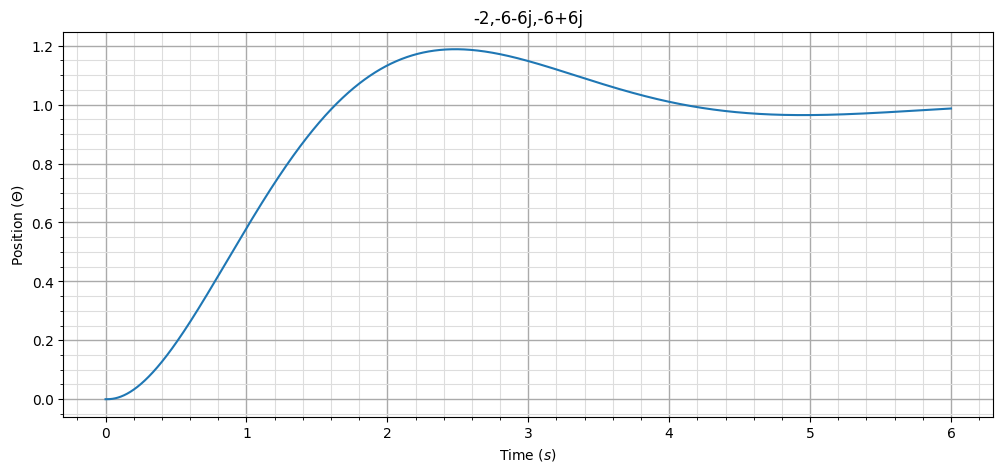

In [ ]:
K = control.acker(A=A, B=B, poles=[-2,-6-6j,-6+6j])
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = '-2,-6-6j,-6+6j'
eval2_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

**Calculations**
* **rise time(10% to 90%):** $\approx$ 1.4s - 0.4s $\approx$ 1.0s
* **settling time (5% margin):** $\approx$ 3.7s
* **overshoot:** $\approx$ 20%

### Pole Set 2

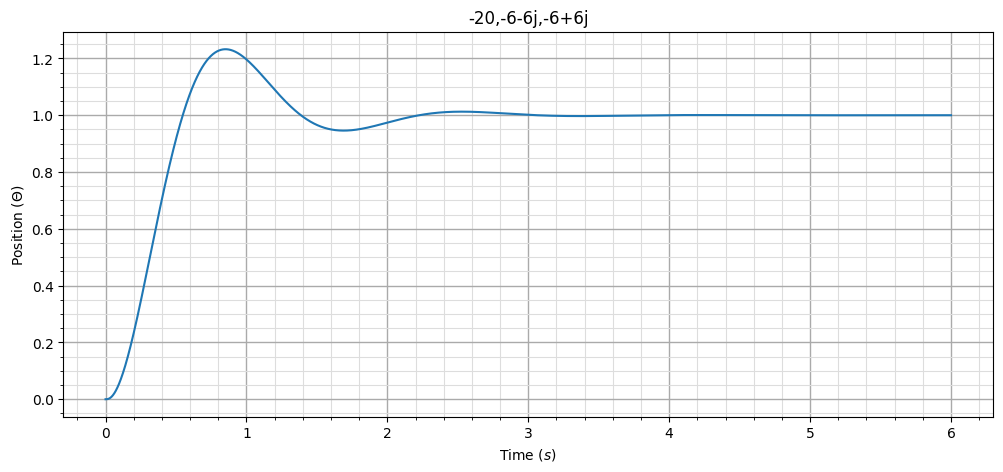

In [ ]:
K = control.acker(A=A, B=B, poles=[-20,-6-6j,-6+6j])
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = '-20,-6-6j,-6+6j'
eval2_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

**Calculations**
* **rise time(10% to 90%):** $\approx$ 0.5s - 0.1s $\approx$ 0.4s
* **settling time (5% margin):** $\approx$ 1.4s
* **overshoot:** $\approx$ 25%

### Pole Set 3

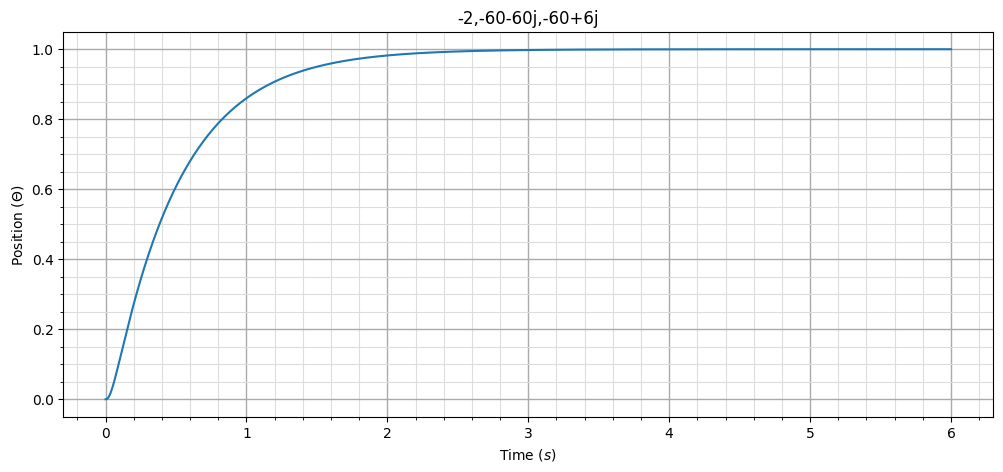

In [ ]:
K = control.acker(A=A, B=B, poles=[-2,-60-60j,-60+6j])
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = '-2,-60-60j,-60+6j'
eval2_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

**Calculations**
* **rise time(10% to 90%):** $\approx$ 1.2s - 0.1s $\approx$ 1.1s
* **settling time (5% margin):** $\approx$ 1.6s
* **overshoot:** 0%

### Reflection

The second set of poles (*-20,-6-6j,-6+6j*) had the fastest rise time. It also had the fastest settling time. The third set of poles (*-2,-60-60j,-60+6j*) had the lowest overshoot - as it didn't overshoot at all.

Overall, these three plots reflect what we learned in class well - there's no pros without cons. No benefits without drawbacks. No free lunch, so to speak. While set 3 had no overshoot, it had the slowest rise time. While set 2 had the fastest rise time, it had the most overshoot. Set 1 is like a jack of all trades, master of none: middle of the road rise time, middle of the road overshoot, the worst settling time.

So, what this shows is the importance of picking our poles by designing them for whatever is important to us: if rise time matters we can design for that, for example. Looking forward to doing that next week!

# Practicum 3-2
Week two!

## Updating our DC Motor constants
Apparently, using our old DC motor constants caused some strange math weirdness with this week's poles, so we're updating our constants to be about an order of magnitude larger in most cases.

Old values:
$$R=1.8\Omega, L=0.85E*10^{-2}H, J=0.032, b=0.035$$
New values:
$$R=10\Omega, L=0.85H, J=0.32, b=0.35$$

In [ ]:
cfg = DCMotorConfig(R=10, L=0.85, Km=4.6, Ktau=6.2, b=0.35, J=0.32)
dcmotor1 = DCMotor(cfg=cfg)
print(cfg)

DCMotorConfig(R=10, L=0.85, b=0.35, J=0.32, Km=4.6, Ktau=6.2)


## Designing our own poles
Last week we arbitrarily used poles we were told to use. This week we will decide what we want the response of our system to look like and go backwards from there to get the poles. Below is a table containing all the useful equations for rise time $T_r$, overshoot $M_p$, and settling time $T_s$.

| Property | Value |
| --- | ----------- |
| Rise time (inverse slope) | $$T_r=\frac{e^{\varphi/\tan{\varphi}}}{\omega_0}$$ |
| Overshoot | $$M_p=e^{-\pi\zeta/\sqrt{1-\zeta^2}} $$ |
| Settling Time (2%) | $$T_s\approx\frac{4}{\zeta\omega_0}$$ | 

Now we will build python functions to derive these mathematically.

### Rise Time (inverse slope)
Rise time equation:
$$T_r=\frac{e^{\varphi/\tan{\varphi}}}{\omega_0} $$
The equation for varphi ($\varphi$):
$$\varphi=\arccos{\zeta}$$

In [ ]:
import math
def rise_time(damping: float,
              omega: float) -> float:
  """Calculate rise time.
  
  damping: float: zeta
  omega: float: omega"""
  var_phi = math.acos(damping)
  e = math.exp(var_phi/math.tan(var_phi))
  return e/omega

### Overshoot
Overshoot equation:
$$M_p=e^{-\pi\zeta/\sqrt{1-\zeta^2}} $$
Solving it for $\zeta$ (damping ratio):
$$\zeta = \frac{1}{\sqrt{\frac{\pi^2}{(\log{M_p})^2}+1}}
$$

In [ ]:
def overshoot(damping: float) -> float:
  """Calculate overshoot given a damping ratio.

  damping: float: zeta
  """
  num = -math.pi * damping
  den = math.sqrt(1 - damping**2)
  return math.exp(num/den)

def damping_ratio(m_p: float) -> float:
  """Calculate damping ratio given an overshoot.

  M_p: float: overshoot
  """
  a = (math.log(m_p))**2
  b = (math.pi**2 / a) + 1
  return 1 / math.sqrt(b)

### Settling Time
The equation for finding settling time is:
$$T_s\approx\frac{4}{\zeta\omega_0}$$
Solving this for $\omega_0$:
$$\omega_0\approx\frac{4}{\zeta T_s}$$

In [ ]:
def omega_0(damping: float,
            t_s:float) -> float:
  """Solve for omega from a settling time.
  
  damping: float: zeta
  t_s: float: setling time"""
  return 4 / (damping*t_s)

### Putting it all together
Now that we have all our important variables defined, we can put them all together in one function to solve for the eivenvalues. This function will:
1. Find damping $\zeta$ from overshoot $M_p$
1. Find omega $\omega_0$ from damping $\zeta$ and settling time $T_s$
1. Use $\omega_0$ and $\zeta$ to find the eigenvalues by implementing the following equation:
$$\lambda=-\zeta\omega_0\pm\omega_0\sqrt{\zeta^2-1}$$

In [ ]:
from cmath import sqrt
def get_eigenvalues(m_p: float,
                    t_s:float,
                    debug:bool = False):
  """Solving for the eigenvalues given overshoot
  and settling time.

  M_p: float: overshoot
  T_S: float: settling time
  """
  damping = damping_ratio(m_p=m_p)
  omega = omega_0(damping=damping, t_s=t_s)
  plus = -1*damping*omega + omega*sqrt(damping**2-1)
  minus = -1*damping*omega - omega*sqrt(damping**2-1)
  if (debug):
    print(f"{damping=} {omega=}")

  return plus, minus

To test out my new function, I'm gonna try the values for this week and compare them to others in the class...

In [ ]:
print(get_eigenvalues(m_p=0.15, t_s=1.0, debug=True))
print(get_eigenvalues(m_p=0.10, t_s=0.5, debug=True))
print(get_eigenvalues(m_p=0.01, t_s=0.1, debug=True))

damping=0.5169308662051556 omega=7.737978637964541
((-4+6.62391979130149j), (-4-6.62391979130149j))
damping=0.5911550337988976 omega=13.532829025560636
((-7.999999999999999+10.915010830734728j), (-7.999999999999999-10.915010830734728j))
damping=0.8260850546139571 omega=48.42116411208123
((-40+27.287527076836824j), (-40-27.287527076836824j))


~~These values match Abdul's, so I think I'm good to go.~~

Turns out I wasn't - we had the same first set of poles but different later sets of poles because I made a PEMDAS error in my **omega_0** function. I originally had:

```  return 4 / damping*t_s``` 

instead of

```  return 4 / (damping*t_s)```,

We didn't notice a discrepency in the first set of poles because with a t_s value of 1.0, the lack of multiplying by it $t_s$ properly didn't change anything.

## Integration
Basically the same integrator as before, but I modified **simulate()** to also return the U values for plotting later. The one design consideration to make note of is the fact that I assume U is 0 at t=0.

In [ ]:
def rk2_step(dyn_func: Callable,
             u_func: Callable,
             x: ArrayLike,
             t: float,
             delta_t: float) -> ArrayLike:
  """Computing f1, f2, and x_k_1. Contains a workaroud
  to the fact that I misunderstood how to write this simulate
  function day1, and have been working with row vectors since,
  when in reality I should've been using columns.
  
  dyn_func: Callable: function being integrated
  u_func: Callable: input function
  x: ArrayLike: x_k value using to estimate x_k_1
  t: float: current time 
  delta_t: float: time step"""
  # Converting the input from a column to a row vector
  x = np.atleast_2d(x).T
  
  f_1 = dyn_func(x=x,u=u_func(t))
  f_2 = dyn_func(x=x + delta_t/2*f_1, u=u_func(t+delta_t/2))

  x_k_1 = x + delta_t*f_2
  # Converting the output from a row to a column vector
  x_k_1 = x_k_1.T
  return x_k_1

def simulate(plant, 
             controller,
             x_0: ArrayLike,
             t_0: float,
             t_f: float,
             delta_t: float) -> Tuple[ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Now we need U history
  u_func = lambda t, state=x_vals[0]: controller(state)
  u_vals = np.zeros(len(t_vals))

  # Using our stepper
  for i in range(1, len(t_vals)):
    u_func = lambda t, state=x_vals[i-1]: controller(state)
    u_vals[i] = u_func(t_vals[i-1])
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
  return t_vals, x_vals, u_vals

## Plotting
Per usual, I made a plotting function to make my life easier. This one is adapted from Practicum 3-1 Evaluation 1. I tried for legitimately like half an hour to enable minor gridlines on these plots like I did in practicum 3-1, but unfortunately it seems to be unsupported in subplots, as far as I can tell. I'm doing [every command necessary](https://stackoverflow.com/questions/19940518/cannot-get-minor-grid-lines-to-appear-in-matplotlib-figure) for it, and it's not working.

In [ ]:
def eval1_plot(plant,
               controller,
               x_0: ArrayLike,
               duration: float, 
               delta_t: float,
               title: str):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  fig = plt.figure(figsize=(10,4))
  axs = fig.subplots(1,2)
  
  # Simulate
  t_vals, x_vals, u_vals = simulate(plant=plant,
                            controller=controller,
                            x_0=x_0,
                            t_0=0,
                            t_f=duration,
                            delta_t=delta_t)
  # Plot
  color = "green"
  # fig, ax1 = plt.subplots
  axs[0].set_xlabel("Time $(s)$", color=color)
  axs[0].set_ylabel("Position $(\Theta)$", color=color)
  axs[0].plot(t_vals, [x[1] for x in x_vals], color=color)
  axs[0].tick_params(axis='y', labelcolor=color)
  axs[0].minorticks_on
  axs[0].grid(which='major', color='#AAAAAA', linewidth=1.0)
  axs[0].grid(which='minor', color=color, linewidth=0.8)
  axs[0].set_title("Output")

  color = '#00118f'
  axs[1].set_ylabel(r"Input (V)", color=color)
  axs[1].set_xlabel("Time $(s)$", color=color)
  axs[1].plot(t_vals, u_vals, color=color)
  axs[1].tick_params(axis='y', labelcolor=color)
  axs[1].minorticks_on
  axs[1].grid(visible=True, which='major', color='#AAAAAA', linewidth=1.0)
  axs[1].grid(visible=True, which='minor', color=color, linewidth=0.8)
  axs[1].set_title("Control Signal")
  
  # Adding appropriate labels
  fig.suptitle(title)
  fig.tight_layout()

## Evaluation 1
Now we get to see if our pole designing works! We have three scenarios to test; each with different overshoot and settling time values.

| Scenario | Given Values |
| ---- | --- |
| 1 | $M_p=0.15$, $T_s=1.0$ |
| 2 | $M_p=0.10$, $T_s=0.5$ |
| 3 | $M_p=0.01$, $T_s=0.1$ |

In [ ]:
cfg = DCMotorConfig(R=10, L=0.85, Km=4.6, Ktau=6.2, b=0.35, J=0.32)
dcmotor1 = DCMotor(cfg=cfg)
duration = 3
delta_t = 0.001

A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C

### Scenario 1

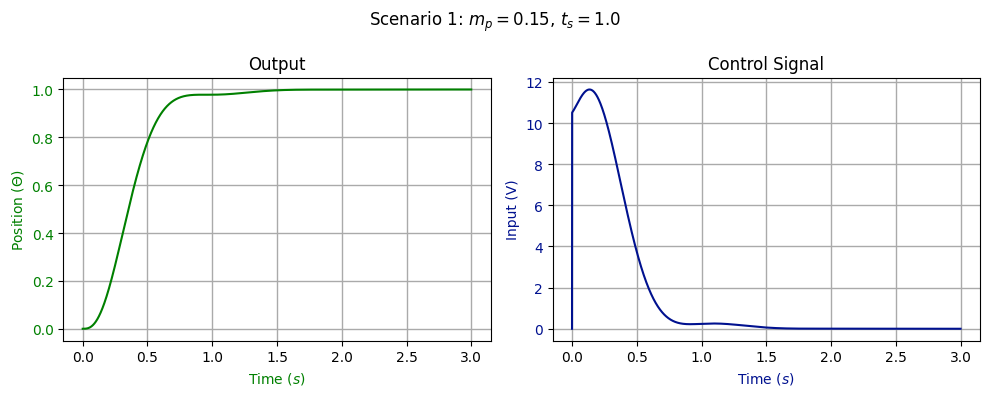

In [ ]:
plus, minus = get_eigenvalues(m_p=0.15, t_s=1.0)
poles = [plus, minus, -4]
K = control.acker(A=A, B=B, poles=poles)
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = 'Scenario 1: $m_p=0.15$, $t_s=1.0$'
eval1_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

Both of our specifications are met! There's less than 15% overshoot and it settles within a second. The control signal also makes sense - a peak at the beginning, a slow decline, and a bit more at the end to make it all the way to 1.0.

### Scenario 2

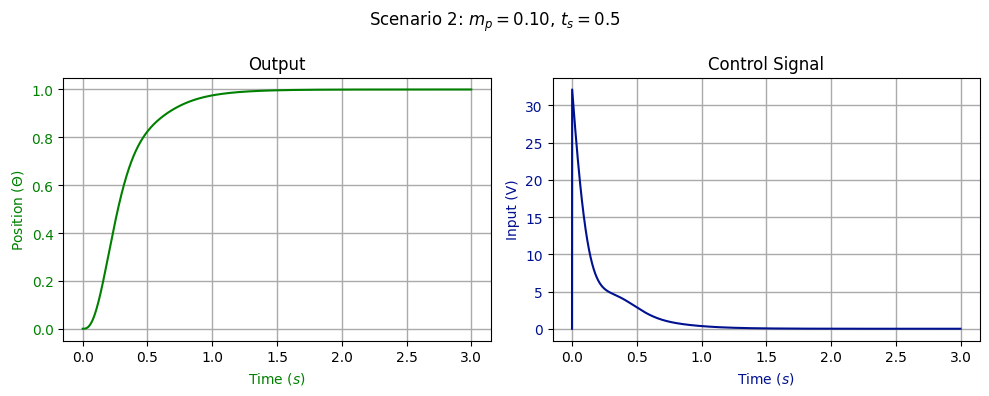

In [ ]:
plus, minus = get_eigenvalues(m_p=0.10, t_s=0.5)
poles = [plus, minus, -4]
K = control.acker(A=A, B=B, poles=poles)
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = 'Scenario 2: $m_p=0.10$, $t_s=0.5$'
eval1_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

Our overshoot was met, but our settling time was not. There's no overshoot, which is within our 10% designed, but the settling time is closer to 0.75 seconds than the desired 0.5. The control signal here also makes sense: peak at the beginning just to immediately decline, which matches the position output.

### Scenario 3

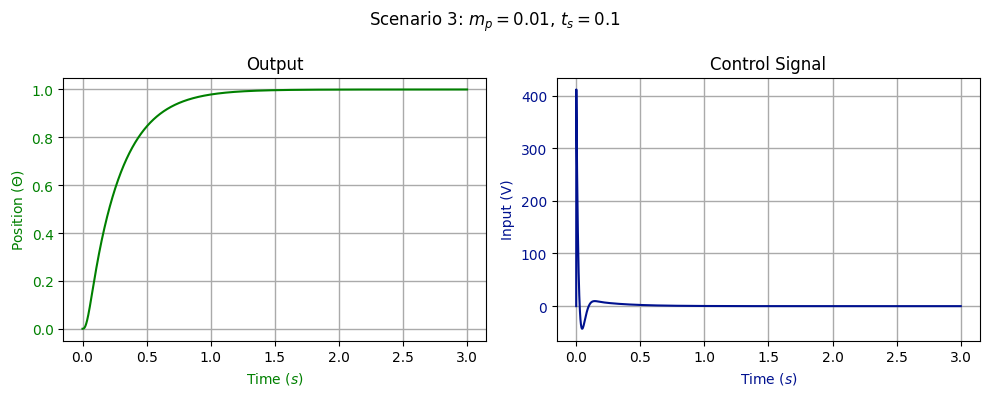

In [ ]:
plus, minus = get_eigenvalues(m_p=0.01, t_s=0.1)
poles = [plus, minus, -4]
K = control.acker(A=A, B=B, poles=poles)
K_f = feedforward_gain(K=K, A=A, B=B, C=C)
title = 'Scenario 3: $m_p=0.01$, $t_s=0.1$'
eval1_plot(plant=dcmotor1,
     controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=1),
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

Once again, overshoot is met(0 overshoot compared to our 0.01 designed value) but settling time is not. This seems like it's because a 0.1s settling time is simply unrealistic for our system to begin with. Like Scenario 2, it seems to be around 0.75s, which indicates that it's the lowest possible *reasonable* settling time for this system. The control signal here continues to make sense and is even more extreme in its peak than Scenario 2, which matches with the much lower desired overshoot value here compared to before (0.01 compared to 0.1).

### Reflection
I would make the assertion that the plots with our custom-picked poles are all *critically damped.* There's basically zero (0) ringing at all. For comparison, last week's (Practicum 3-1 with the arbitrarily chosen poles) had two under-damped plots with one critically damped.

The main interesting thing to note here is the law of diminishing returns - and/or physical practical reality. Scenarios 2 and 3 from this week have significantly different designed settling times but have nearly the same *actual* settling times - as discussed in scenario 3's discussion, I think this is just because of physical restraints of the system. 

**TL;DR:** designing poles is cool and helpful and produces much better output than picking them arbitrarily, but there are still physical, real-world constraints that these systems run into.